## Makeup Visual Analytics Assignment

This notebook uses the [appliance energy prediction data set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) from the UCI Machine Learning Repository. This notebook will:

(1) download the data set from the UCI machine learning repository
(2) load (and clean) the data
(3) do a visual exploration of the data using Yellowbrick with accompanying text interpretation
(4) fit and visually compare two or more Scikit-Learn models using Yellowbrick, providing text interpretation (at the very end)

In [30]:
#import everything
import os
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression, LassoCV, RidgeCV, ElasticNetCV, SGDRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot, AlphaSelection
from sklearn.metrics import mean_squared_error as mse, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from yellowbrick.features import Rank2D
%matplotlib inline

# Ignore warnings in the Notebook
import warnings
warnings.filterwarnings('ignore')

In [79]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv'

def download_data(url, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)

    response = requests.get(url)
    name = os.path.basename(url)
    with open(os.path.join(path, name), 'wb') as f:
        f.write(response.content)
        
download_data(data_url)

In [124]:
#read in the data
data = pd.read_csv('data/energydata_complete.csv')

In [125]:
data.shape

(19735, 29)

In [126]:
data.columns = ['date', 'energy_use', 'lights', 'temp_kitchen','humid_kitchen', 'temp_living', 'humid_living',
    'temp_laundry', 'humid_laundry', 'temp_office', 'humid_office', 'temp_bath','humid_bath', 'temp_north',
    'humid_north', 'temp_ironing', 'humid_ironing', 'temp_teen', 'humid_teen', 'temp_parent', 'humid_parent',
    'temp_outside', 'pressure', 'humid_outside', 'windspeed', 'visibility', 'dewpoint', 'rand1', 'rand2']

In [127]:
data.head()

,date,energy_use,lights,temp_kitchen,humid_kitchen,temp_living,humid_living,temp_laundry,humid_laundry,temp_office,...,temp_parent,humid_parent,temp_outside,pressure,humid_outside,windspeed,visibility,dewpoint,rand1,rand2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [128]:
data.describe()

,energy_use,lights,temp_kitchen,humid_kitchen,temp_living,humid_living,temp_laundry,humid_laundry,temp_office,humid_office,...,temp_parent,humid_parent,temp_outside,pressure,humid_outside,windspeed,visibility,dewpoint,rand1,rand2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


Based on the above, the dataset seems to be relatively clean. The distribution of `lights` (energy use of light fixtures in the house in Wh) seems suspect, but I'll still include it because I don't know enough about the data collection to say if these are true 0's or just  missing.

I Googled best practices on how to handle dates in machine learning and decided to convert them into day of week (likely important here for trends in weekday vs weekend energy usage) and absolute time (to try and capture seasonality with energy usage). Then I drop the date field for machine learning.

In [155]:
import datetime as dt

data['date'] = data['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))
data['day_of_week'] = data['date'].dt.dayofweek

data['date_value'] = test['date'].astype('int64')//1e12

data.head()

,date,energy_use,lights,temp_kitchen,humid_kitchen,temp_living,humid_living,temp_laundry,humid_laundry,temp_office,...,temp_outside,pressure,humid_outside,windspeed,visibility,dewpoint,rand1,rand2,day_of_week,date_value
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,0,1452531
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,0,1452532
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,0,1452532
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,0,1452533
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,0,1452534


In [9]:
outcome = data.energy_use

In [10]:
columns_to_remove = ["date", "energy_use", "rand1", "rand2"]
cols = [col for col in data.columns if col not in columns_to_remove]
data_for_ml = data[cols]
del(columns_to_remove, cols)

In [11]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(data_for_ml, outcome, 
                                                        test_size=0.33, random_state=42)

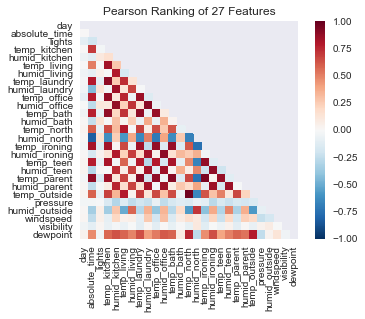

In [21]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(data_for_ml)
visualizer.poof()

The above visualizes Pearson correlations between all pairs of features, and here it is showing that several of the features are correlated. This is not surprising as there shouldn't be vast differences in temperatures or humidities across different rooms of the same house. Similarly, it makes sense that the temperature and humidity on the northern side of the building is correlated with the humidity and temperature outside. 

The below Joint Plot normalizes and dives deeper on this specific correlation -- it's a scatter diagram of the temperature on the north side of the building on the x axis and the temperature outside on the y axis with a line of best fit. Again, this correlation is logical. 

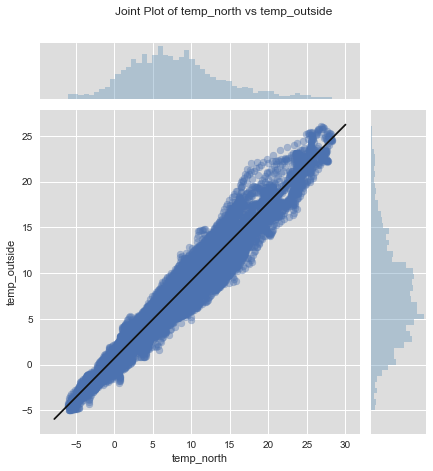

In [22]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='temp_north', target='temp_outside')
visualizer.fit(data_for_ml['temp_north'], data_for_ml['temp_outside'])
visualizer.poof()

## Linear Regression

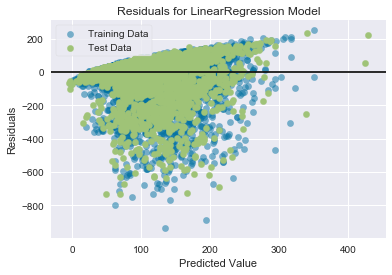

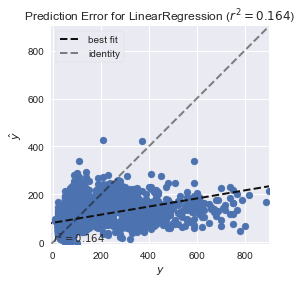

In [40]:
# Fit Model
LinRegr = LinearRegression()
LinRegr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(LinRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(LinRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

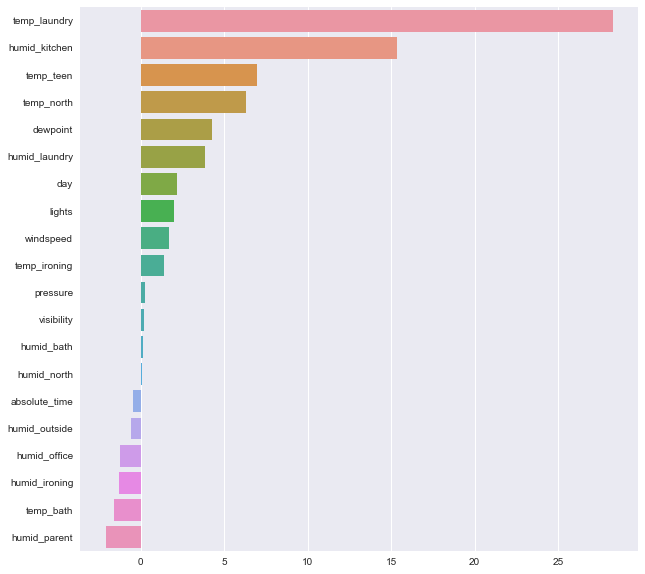

In [41]:
coefficients = LinRegr.coef_
Top10 = np.argsort(coefficients)[::-1][0:20]
Top10_Features = X_train.columns[Top10]
Top10_Importances = coefficients[Top10]
Top10_Importances
plt.figure(figsize=(10, 10))
sns.barplot(x = Top10_Importances, y = Top10_Features)

In [18]:
LNR = LinearRegression()
cross_validate(LNR, X = X_train, y = y_train, cv = 12)

{'fit_time': array([ 0.05456924,  0.01167512,  0.01167178,  0.024508  ,  0.01179862,
         0.009835  ,  0.01011682,  0.01015997,  0.01071191,  0.00937796,
         0.0093019 ,  0.00965309]),
 'score_time': array([ 0.00364614,  0.00085092,  0.0012033 ,  0.00071096,  0.00110102,
         0.00069404,  0.00075221,  0.00115085,  0.00075507,  0.00075793,
         0.00075912,  0.00073886]),
 'test_score': array([ 0.11885006,  0.10730905,  0.17052795,  0.17229219,  0.18332198,
         0.19580377,  0.17483928,  0.14613773,  0.17984589,  0.15790695,
         0.17900233,  0.18114862]),
 'train_score': array([ 0.17304407,  0.17359758,  0.16769637,  0.16767755,  0.16669182,
         0.16542004,  0.16728527,  0.16952785,  0.16702734,  0.16895266,
         0.1667537 ,  0.16705149])}

### Lasso Regression

## SVR Regression

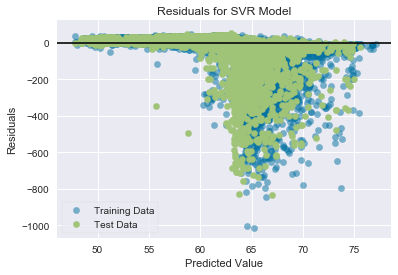

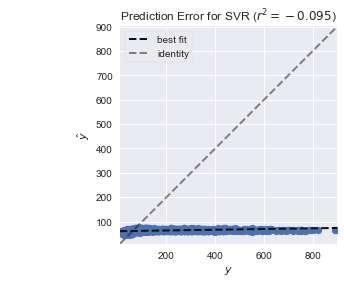

In [42]:
# Fit Model
SVR_Regr = SVR()
SVR_Regr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(SVR_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(SVR_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

In [17]:
SVR = SVR()
cross_validate(SVR, X = X_train, y = y_train, cv = 12)

{'fit_time': array([ 14.80072808,  13.94709611,  13.43926716,  13.85586619,
         13.40339589,  13.49995422,  13.30350018,  13.38170004,
         13.32216096,  13.99681306,  13.28673005,  13.39980602]),
 'score_time': array([ 0.62644196,  0.63353801,  0.62794805,  0.69465089,  0.64484191,
         0.64516187,  0.65720177,  0.63092017,  0.62442183,  0.70689273,
         0.62583017,  0.64815092]),
 'test_score': array([-0.1083524 , -0.09632626, -0.08120018, -0.08615962, -0.10096034,
        -0.11433156, -0.08864874, -0.08730762, -0.08318286, -0.08447181,
        -0.10766815, -0.09954589]),
 'train_score': array([-0.08507257, -0.08585895, -0.08635427, -0.0862894 , -0.0857686 ,
        -0.08425681, -0.08589818, -0.08575198, -0.08642055, -0.08696341,
        -0.08457004, -0.08543337])}

## Elastic Net Regression

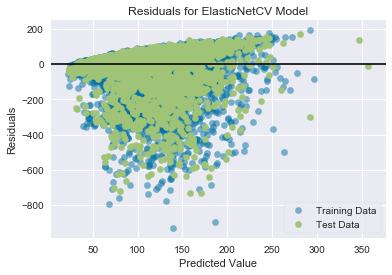

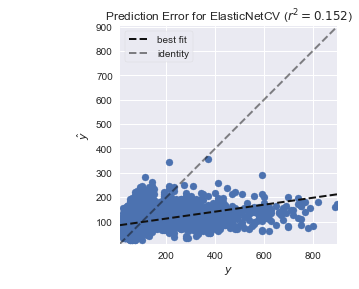

In [65]:
#Fit the model
ElasticNetRegr = ElasticNetCV()
ElasticNetRegr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(ElasticNetRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(ElasticNetRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

In [16]:
EN = ElasticNetCV()
cross_validate(GB, X = X_train, y = y_train, cv = 12)

{'fit_time': array([ 2.13073683,  2.29720926,  2.31483483,  2.34662509,  2.35307097,
         2.09240985,  2.06667423,  2.12037492,  2.6650219 ,  2.23378992,
         2.32191801,  2.26951003]),
 'score_time': array([ 0.00310612,  0.00273085,  0.00286102,  0.00467801,  0.00248194,
         0.00364017,  0.00280285,  0.00384402,  0.00254321,  0.00398326,
         0.00276804,  0.00301003]),
 'test_score': array([ 0.24968318,  0.16283316,  0.24855988,  0.29449963,  0.27033209,
         0.30909372,  0.28701096,  0.27043622,  0.32144739,  0.22656561,
         0.27539737,  0.25778024]),
 'train_score': array([ 0.3651963 ,  0.37804256,  0.36975512,  0.35606681,  0.36625157,
         0.36065268,  0.36579233,  0.37837915,  0.36456846,  0.3716003 ,
         0.37134885,  0.36756858])}

## Gradient Boosting Regressor

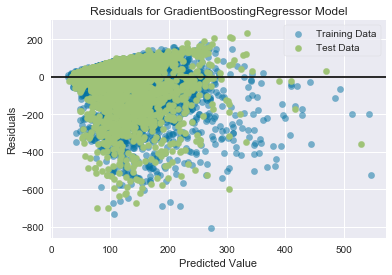

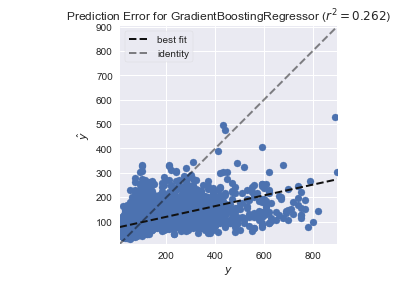

In [63]:
# Fit Model
GradBoost_Regr = GradientBoostingRegressor()
GradBoost_Regr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(GradBoost_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(GradBoost_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

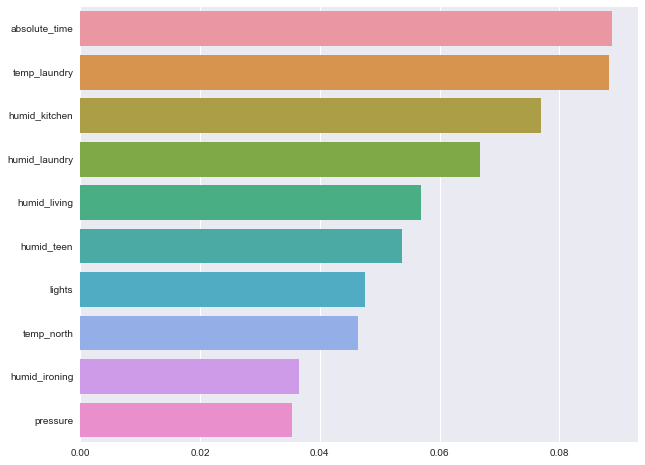

In [64]:
importances = GradBoost_Regr.feature_importances_
Top10 = np.argsort(importances)[::-1][0:10]
Top10_Features = X_train.columns[Top10]
Top10_Importances = importances[Top10]
Top10_Importances
plt.figure(figsize=(10, 8))
sns.barplot(x = Top10_Importances, y = Top10_Features)

In [15]:
GB = GradientBoostingRegressor()
cross_validate(GB, X = X_train, y = y_train, cv = 12)

{'fit_time': array([ 1.96225715,  1.93084192,  1.91490889,  2.00678611,  2.57722282,
         2.8335681 ,  2.69683719,  2.78209901,  2.22031188,  2.48075318,
         2.32901502,  2.2526269 ]),
 'score_time': array([ 0.00305676,  0.00299096,  0.00254202,  0.00242996,  0.00330019,
         0.0026679 ,  0.00355506,  0.00329804,  0.00264502,  0.00293517,
         0.00394702,  0.00266695]),
 'test_score': array([ 0.24786204,  0.16458925,  0.24851741,  0.29450814,  0.27173525,
         0.3096645 ,  0.28732755,  0.26698367,  0.31869124,  0.22381225,
         0.27149375,  0.25056005]),
 'train_score': array([ 0.3651963 ,  0.37804256,  0.36975512,  0.35606681,  0.36625157,
         0.36065262,  0.36579233,  0.37837915,  0.36456846,  0.3716003 ,
         0.37134885,  0.36756858])}

## Random Forest Regressor

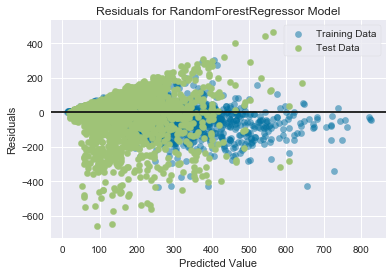

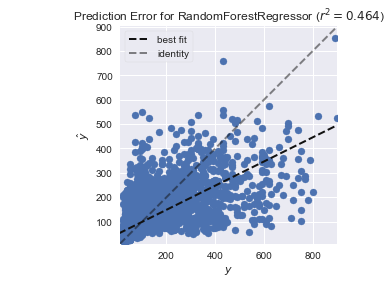

In [12]:
# Fit Model
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(RF)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(RF)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

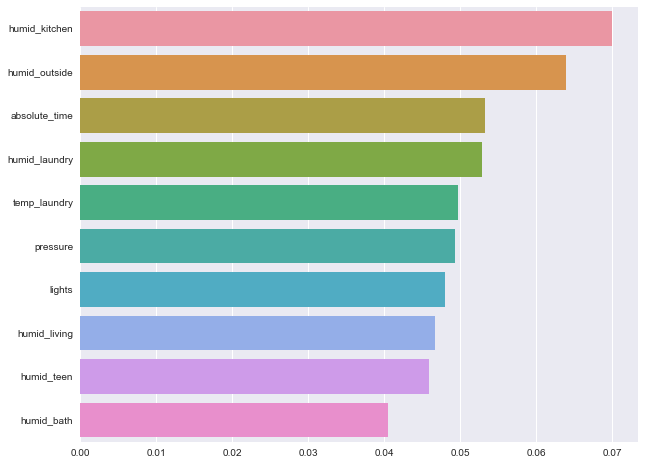

In [13]:
importances = RF.feature_importances_
Top10 = np.argsort(importances)[::-1][0:10]
Top10_Features = X_train.columns[Top10]
Top10_Importances = importances[Top10]
Top10_Importances
plt.figure(figsize=(10, 8))
sns.barplot(x = Top10_Importances, y = Top10_Features)

In [14]:
RF = RandomForestRegressor()
cross_validate(RF, X = X_train, y = y_train, cv = 12)

{'fit_time': array([ 2.97328806,  2.88903403,  3.23707604,  3.16596317,  2.88864684,
         3.00639081,  2.97553205,  2.81079912,  2.89104581,  2.8712039 ,
         3.0179801 ,  3.08643389]),
 'score_time': array([ 0.00576091,  0.00596809,  0.00745487,  0.006042  ,  0.005409  ,
         0.0061202 ,  0.0048399 ,  0.00539875,  0.0047121 ,  0.00674009,
         0.0072329 ,  0.00636816]),
 'test_score': array([ 0.40767421,  0.34412879,  0.40893623,  0.51569813,  0.42309658,
         0.45427376,  0.42268408,  0.45432509,  0.48017318,  0.27550387,
         0.43274297,  0.37266198]),
 'train_score': array([ 0.90289751,  0.90276946,  0.89826245,  0.89447967,  0.89318821,
         0.89506214,  0.89322585,  0.89488862,  0.89771866,  0.89736153,
         0.89600199,  0.89851442])}

<b>Analysis</b>:

All of the models had some level of heteroskedasticity to them where the error fanned out/grew into that cone shape. So while error is low when the predicted value (energy use) is low, error grows significantly with higher predicted energy use. 

The prediction error graphs for each model (especially SVM) show the prediction fit line off from the 45 degree line, indicating that the predictions are far from matching the model.

The r2 values for Linear, SVR Regressor, Elastic Net were all fairly low (-1 to 1.6), indicating poor performance for these models.

The r2 value for the Random Forest Regressor was a 0.461, showing that it did better than the other models, but that residual and prediction error visuals still show that the errors are heteroskedastic. So while the Random Forest Regressor performed better than the other models, it still isn't a great fit. In terms of the most predictive features, only the humidity features were found to be predictive which was interesting. While it's not shocking that the kitchen, the room with the most appliances, was very predictive, I can't reconcile why humidity rather than temperature features were the most predictive.

For the Linear, SVR, Elastic Net, and Gradient models, errors for both the test and training sets are consistent. However, while the Random Forest model has the highest r2 value, the test/train errors don't fit, perhaps indicating that the model is either overfit or underfit.

After I went through this, I found the [paper](http://www.sciencedirect.com/science/article/pii/S0378778816308970?via%3Dihub) that this dataset was created for -- while I couldn't access the full paper, the abstract showed that the Gradient Boosting model performed the best, explaining 57% of the test set when using all of the predictors. However, my model only had an r2 value of .262. I wish I could check 1. the error plots in the paper (to see if it's as hetereoskedastic), 2. if they treated time differently, 3. any additional cleaning steps they did to the data to perhaps explain this difference. I initially assumed this is due to specific test/train sets, but they included some language around reproducibility, so it must be something else.  
In both my model and what is in the abstract, the laundry, living room, and kitchen temperature features were the most predictive of energy use, which was different from the random forest regressor that found the humidity features to be the most predictive. This makes more sense to me than the humidity features used in the Random Forest model. 